In [59]:
import math

def mkMag(flux):
    return -2.5*math.log(flux/3631.)/math.log(10.)

In [156]:
T = Table(names=("id", "ra", "dec", "dist", "r", "g", "i", "r_r", "r_g", "r_i", "s_r", "s_g", "s_i"), 
          dtype=('i', 'S12', 'S12', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f'))

In [169]:
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
from lsst.meas.algorithms import loadIndexedReferenceObjects as load_IRO
from astropy.table import Table

filt = ['r', 'g', 'i']
patch = '3,4'

butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/clusters/MACSJ2243.3-0935/output/coadd_dir")

dataId_r = {'tract':0, 'filter':'r', 'patch':patch}
dataId_g = {'tract':0, 'filter':'g', 'patch':patch}
dataId_i = {'tract':0, 'filter':'i', 'patch':patch}

meas_r = butler.get('deepCoadd_meas', dataId=dataId_r)
meas_g = butler.get('deepCoadd_meas', dataId=dataId_g)
meas_i = butler.get('deepCoadd_meas', dataId=dataId_i)

md_r = butler.get('deepCoadd_calexp', dataId=dataId_r)
md_g = butler.get('deepCoadd_calexp', dataId=dataId_g)
md_i = butler.get('deepCoadd_calexp', dataId=dataId_i)

calib_r = md_r.getCalib()
calib_g = md_g.getCalib()
calib_i = md_i.getCalib()

info = md_r.getInfo()
wcs = info.getWcs()
coord = wcs.pixelToSky(0, 0)
print "Coordinate of reference point in patch", coord.getRa().asDegrees(), coord.getDec().asDegrees()

lConfig = load_IRO.LoadIndexedReferenceObjectsConfig(ref_dataset_name = 'sdss')
lTask = load_IRO.LoadIndexedReferenceObjectsTask(butler, config = lConfig)

refCat = lTask.loadSkyCircle(coord, afwGeom.Angle(2., afwGeom.degrees), 'R')

schema = meas_r.getSchema()

#fluxFlagKey = schema["modelfit_CModel_flag"].asKey()
fluxFlagKey = schema["base_PsfFlux_flag"].asKey()
#fluxKey = schema["modelfit_CModel_flux"].asKey()
fluxKey = schema["base_PsfFlux_flux"].asKey()
fluxSigmaKey = schema["modelfit_CModel_fluxSigma"].asKey()
extKey = schema["base_ClassificationExtendedness_value"].asKey()
extFlagKey = schema["base_ClassificationExtendedness_flag"].asKey()
idKey = schema["id"].asKey()
raKey = schema["coord_ra"].asKey()
decKey = schema["coord_dec"].asKey()

Coordinate of reference point in patch 341.230106749 -10.323160499


In [170]:
# Color corrections CFHT --> SDSS
u_SDSS_ug  = (lambda u_Mega, g_Mega : u_Mega +0.181*(u_Mega - g_Mega))
g_SDSS_gr  = (lambda g_Mega, r_Mega : g_Mega +0.195*(g_Mega - r_Mega))
g_SDSS_gi  = (lambda g_Mega, i_Mega : g_Mega +0.103*(g_Mega - i_Mega))
r_SDSS_gr  = (lambda r_Mega, g_Mega : r_Mega +0.011*(g_Mega - r_Mega))
i_SDSS_ri  = (lambda i_Mega, r_Mega : i_Mega +0.079*(r_Mega - i_Mega))
i_SDSS_gi  = (lambda i_Mega, g_Mega : i_Mega +0.044*(g_Mega - i_Mega))
i2_SDSS_ri = (lambda i2_Mega, r_Mega : i2_Mega +0.001*(r_Mega - i2_Mega))
i2_SDSS_gi = (lambda i2_Mega, g_Mega : i2_Mega -0.003*(g_Mega - i2_Mega))
z_SDSS_iz  = (lambda z_Mega, i_Mega : z_Mega -0.099*(i_Mega - z_Mega))


#T = Table(names=("id", "ra", "dec", "dist", "r", "g", "i", "r_r", "r_g", "r_i", "s_r", "s_g", "s_i"), 
#          dtype=('i', 'S12', 'S12', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f'))

match = afwTable.matchRaDec(refCat.refCat, meas_r, afwGeom.Angle(1./3600., afwGeom.degrees))
print "Nbr. of matches:", len(match)

#print match[0].first.getSchema().getOrderedNames()

for m in match :
    ref_r = mkMag(m.first.get('R_flux'))
    if not m.first.get("photometric") :
        continue
    if m.second.get(fluxFlagKey) or m.second.get(extFlagKey) :
        continue
    if m.second.get(extKey) > 0.5 :
        continue
    id = m.second.get(idKey)
    flux_r = m.second.get(fluxKey)
    if flux_r < 0 :
        continue
     
    ra = afwGeom.radToDeg(m.second.get(raKey))
    dec = afwGeom.radToDeg(m.second.get(decKey))
    
    ref_g = mkMag(m.first.get('G_flux'))
    ref_i = mkMag(m.first.get('I_flux'))   
        
    flux_g = meas_g.find(id).get(fluxKey)
    flux_i = meas_i.find(id).get(fluxKey)
    if flux_g < 0 or flux_i < 0 :
        continue
    if meas_g.find(id).get(fluxFlagKey) or meas_i.find(id).get(fluxFlagKey) :
        continue
    
    mag_r = calib_r.getMagnitude(flux_r)
    mag_g = calib_g.getMagnitude(flux_g)
    mag_i = calib_i.getMagnitude(flux_i)
    
    dist = afwGeom.radToMas(m.distance)
    
    gSDSS = g_SDSS_gr(mag_g, mag_r)
    rSDSS = r_SDSS_gr(mag_r, mag_g)
    iSDSS = i2_SDSS_gi(mag_i, mag_g)
    
    T.add_row((id, ra, dec, dist, mag_r, mag_g, mag_i, ref_r, ref_g, ref_i, rSDSS, gSDSS, iSDSS))
    
print len(T)

Nbr. of matches: 263
833


In [151]:
print T

    id         ra          dec        dist  ...   r_i     s_r     s_g     s_i  
--------- ------------ ------------ ------- ... ------- ------- ------- -------
402653277 340.68918846 -9.710104354 28.1699 ...  19.925 20.0331 20.3522 19.9566
402653509 340.79604063 -9.705328976 24.5887 ... 18.9971  19.509 20.9072 18.9693
402673970 340.78579554 -9.700178350 50.2228 ... 19.4295 19.8689  21.074 19.4352
402674119 340.62896122 -9.700149147 228.585 ... 20.2742 21.7661 23.4014 20.3154
402653735 340.68262771 -9.699178063 333.707 ... 20.2607 21.6306 23.1253 20.3097
402674168 340.61014820 -9.698864470 178.929 ... 21.1787 21.9276 23.5157 21.1647
402653802 340.66669496 -9.697429456 10.6472 ... 20.1125 21.1021 22.6587 20.1187
402653878 340.62095554 -9.695484703 118.761 ... 20.1829 21.0992 22.5188 20.2754
402653890 340.77507738 -9.694812252  266.73 ... 18.9476 19.5375 21.0259 18.9273
402653921 340.76373968 -9.694180643 54.2903 ... 17.8299  18.033 18.7266 17.8135
      ...          ...          ...     

116.782769561 140.943348408 134.42620635


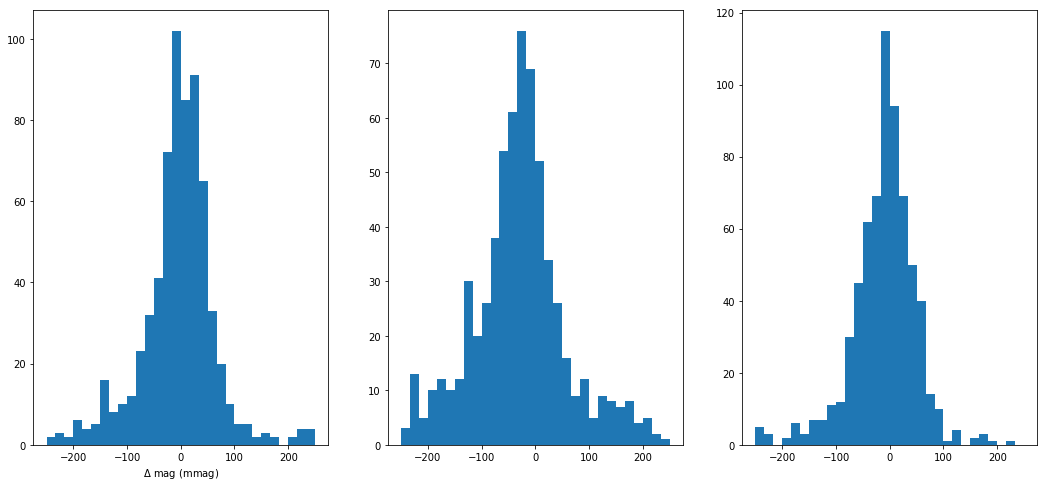

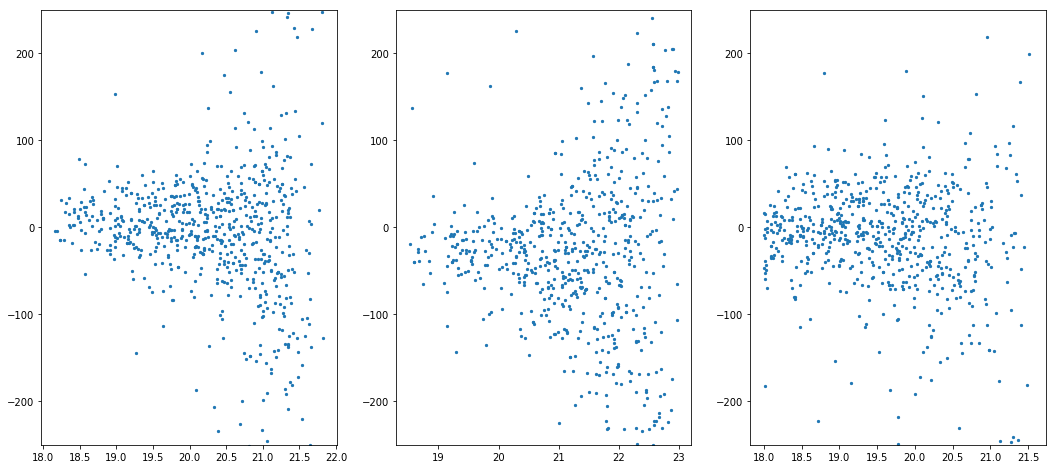

In [183]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 8))

f = (T["r_i"] > 18.0) & (T["r_g"] < 23)

ax0.hist((T["r_r"][f]-T["s_r"][f])*1000., bins=30, range=[-250., 250.])
ax0.set_xlabel("$\Delta$ mag (mmag)")
ax1.hist((T["r_g"][f]-T["s_g"][f])*1000., bins=30, range=[-250., 250.])
ax2.hist((T["r_i"][f]-T["s_i"][f])*1000., bins=30, range=[-250., 250.])

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 8))
ax0.scatter(T["r_r"][f], (T["r_r"][f]-T["s_r"][f])*1000., s=5)
ax0.set_ylim([-250, 250])
ax1.scatter(T["r_g"][f], (T["r_g"][f]-T["s_g"][f])*1000., s=5)
ax1.set_ylim([-250, 250])
ax2.scatter(T["r_i"][f], (T["r_i"][f]-T["s_i"][f])*1000., s=5)
ax2.set_ylim([-250, 250])

print np.std(T["r_r"][f]-T["s_r"][f])*1000., np.std(T["r_g"][f]-T["s_g"][f])*1000., np.std(T["r_i"][f]-T["s_i"][f])*1000.

In [98]:
print schema.getOrderedNames()

[u'id', u'coord_ra', u'coord_dec', u'parent', u'flags_negative', u'merge_footprint_i', u'merge_footprint_r', u'merge_footprint_z', u'merge_footprint_g', u'merge_footprint_u', u'merge_footprint_sky', u'merge_peak_i', u'merge_peak_r', u'merge_peak_z', u'merge_peak_g', u'merge_peak_u', u'merge_peak_sky', u'deblend_nChild', u'deblend_deblendedAsPsf', u'deblend_psfCenter_x', u'deblend_psfCenter_y', u'deblend_psfFlux', u'deblend_tooManyPeaks', u'deblend_parentTooBig', u'deblend_masked', u'deblend_skipped', u'deblend_rampedTemplate', u'deblend_patchedTemplate', u'deblend_hasStrayFlux', u'base_GaussianCentroid_x', u'base_GaussianCentroid_y', u'base_GaussianCentroid_flag', u'base_GaussianCentroid_flag_noPeak', u'base_NaiveCentroid_x', u'base_NaiveCentroid_y', u'base_NaiveCentroid_flag', u'base_NaiveCentroid_flag_noCounts', u'base_NaiveCentroid_flag_edge', u'base_SdssCentroid_x', u'base_SdssCentroid_y', u'base_SdssCentroid_xSigma', u'base_SdssCentroid_ySigma', u'base_SdssCentroid_flag', u'base_S